# 목표

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.	분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다. 


In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/Untitled Folder 4/news_summary_more.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


text만 중복을 제거해주는 이유는 headlines 에서 간단하게 하는 경우 겹칠수도 있기 때문입니다.

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []

clean_text = [preprocess_sentence(text) for text in data['text']]

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_summary = []

clean_summary = [preprocess_sentence(text) for text in data['headlines']]

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386


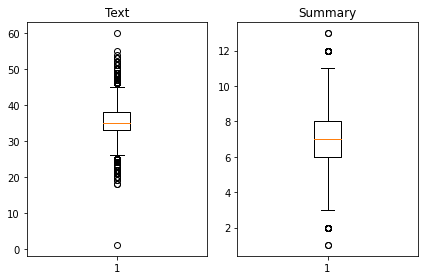

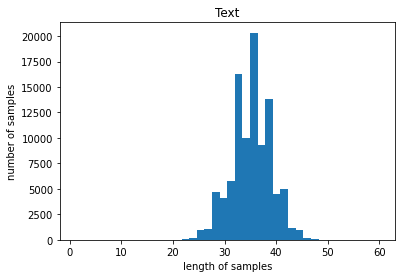

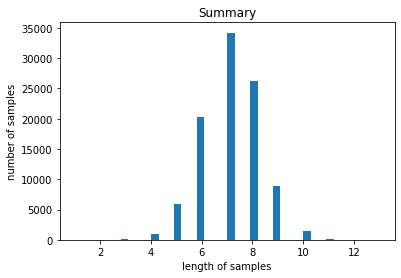

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 50
summary_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9999796665311103


In [18]:
data = data[data['text'].str.split().str.len() <= text_max_len]

data = data[data['headlines'].str.split().str.len() <= summary_max_len]

In [19]:
#토큰화

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[88050 98340 38787 ... 61404 22129 19895]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19668


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [23]:
#토크나이저

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69811
등장 빈도가 6번 이하인 희귀 단어의 수: 47680
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22131
단어 집합에서 희귀 단어의 비율: 68.2986921831803
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5043361497423806


In [24]:
src_vocab = 22214 # 69569-47355로 개수를 정했습니다.
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [25]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[79, 3644, 2287, 420, 1240, 12247, 1268, 7766, 1249, 2490, 76, 184, 8130, 278, 941, 8130, 278, 941, 47, 468, 229, 61, 1022, 278, 18393, 194, 1840, 18393, 719, 32, 2287, 12247, 2126], [5870, 7, 408, 3645, 1242, 573, 174, 2949, 15, 11568, 169, 408, 2966, 18394, 20675, 6808, 9472, 1909, 3033, 2429, 19437, 3645, 159, 3353, 444, 1009, 2886, 15, 248, 15, 401, 214, 402], [27, 828, 15335, 9309, 261, 2227, 2, 70, 40, 584, 63, 1, 4819, 4980, 1939, 2150, 246, 299, 400, 3491, 1826, 2150, 117, 4189, 4, 3, 13, 1895, 1573, 2430, 1362, 703, 70]]


In [26]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [27]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29880
등장 빈도가 5번 이하인 희귀 단어의 수: 19611
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10269
단어 집합에서 희귀 단어의 비율: 65.63253012048193
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.876095245980258


In [28]:
tar_vocab = 29949-19628 #
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1915, 302, 38, 6712, 650, 1486, 36], [1, 22, 279, 2059, 1682, 9413, 6038, 5279], [1, 771, 1041, 53, 330], [1, 1230, 75, 559, 5, 2487, 5756, 85, 581], [1, 40, 207, 224, 7, 535, 10271]]
target
decoder  [[1915, 302, 38, 6712, 650, 1486, 36, 2], [22, 279, 2059, 1682, 9413, 6038, 5279, 2], [771, 1041, 53, 330, 2], [1230, 75, 559, 5, 2487, 5756, 85, 581, 2], [40, 207, 224, 7, 535, 10271, 2]]


In [29]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78674
훈련 레이블의 개수 : 78674
테스트 데이터의 개수 : 19667
테스트 레이블의 개수 : 19667


In [30]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.models import Model

# 모델 하이퍼파라미터 설정
embedding_dim = 128  # 임베딩 차원
hidden_units = 256  # LSTM hidden state 크기
max_text_len = 50  # 원문 최대 길이
max_summary_len = 12  # 요약문 최대 길이

# 인코더 (1층 LSTM)
encoder_inputs = Input(shape=(max_text_len,))
encoder_embedding = Embedding(input_dim=src_vocab, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.3)  # LSTM 층을 1개만 사용
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# 디코더 (1층 LSTM)
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=tar_vocab, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.3)  # LSTM 층을 1개만 사용
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# 어텐션 (Attention)
attention_layer = Attention()
attention_result = attention_layer([decoder_outputs, encoder_outputs])  # 디코더가 인코더의 중요한 부분을 집중

# 어텐션 결합
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_result])
decoder_dense = Dense(tar_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# 모델 생성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# 모델 구조 확인
model.summary()

from tensorflow.keras.callbacks import EarlyStopping



In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

embedding_dim = 128  # 임베딩 차원
hidden_units = 256  # LSTM hidden state 크기
max_text_len = 50  # 원문 최대 길이
max_summary_len = 12  # 요약문 최대 길이

# 1️⃣ 인코더 (1층 LSTM)
encoder_inputs = Input(shape=(max_text_len,))
encoder_embedding = Embedding(input_dim=src_vocab, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.2)  # Dropout 줄이기
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# 2️⃣ 디코더 (1층 LSTM)
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=tar_vocab, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.2)  # Dropout 줄이기
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# 3️⃣ 어텐션 (Attention)
attention_layer = Attention()
attention_result = attention_layer([decoder_outputs, encoder_outputs])  # 어텐션 적용

# 4️⃣ 어텐션 결합
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_result])
decoder_dense = Dense(tar_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# 5️⃣ 모델 생성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 6️⃣ 모델 컴파일 (Adam 사용)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# 7️⃣ 모델 구조 확인
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2843392     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 128)      1321088     input_2[0][0]                    
______________________________________________________________________________________________

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# 
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# 배치 크기 줄이기 
history = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,  
    callbacks=[es], 
    epochs=50  
)

Epoch 1/50
308/308 [==============================] - 17s 54ms/step - loss: 3.5490 - val_loss: 3.4868
Epoch 5/50
308/308 [==============================] - 17s 54ms/step - loss: 3.2465 - val_loss: 3.3134
Epoch 6/50
308/308 [==============================] - 17s 55ms/step - loss: 2.9897 - val_loss: 3.1861
Epoch 7/50
308/308 [==============================] - 17s 56ms/step - loss: 2.7678 - val_loss: 3.0998
Epoch 8/50
308/308 [==============================] - 17s 56ms/step - loss: 2.5723 - val_loss: 3.0355
Epoch 9/50
308/308 [==============================] - 17s 57ms/step - loss: 2.3973 - val_loss: 2.9949
Epoch 10/50
308/308 [==============================] - 18s 57ms/step - loss: 2.2420 - val_loss: 2.9663
Epoch 11/50
308/308 [==============================] - 17s 57ms/step - loss: 2.1008 - val_loss: 2.9574
Epoch 12/50
308/308 [==============================] - 17s 57ms/step - loss: 1.9730 - val_loss: 2.9474
Epoch 13/50
308/308 [==============================] - 17s 57ms/step - loss: 1.

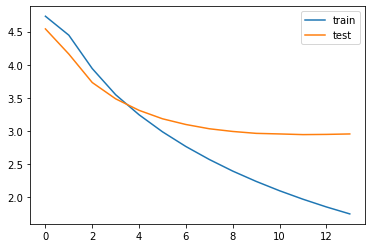

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [36]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

hidden_size=256

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = decoder_embedding(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

TypeError: 'KerasTensor' object is not callable

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

NameError: name 'attn_layer' is not defined

In [39]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [40]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [41]:
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):  # SOS, EOS 제거
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()  

In [42]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : filmmaker subhash ghai whose film completed years sunday said idea guy aishwarya rai song actor shahid kapoor wanted good looking boy asked added subhash said know going become big star 
실제 요약 : guy aish shahid kapoor subhash ghai


NameError: name 'decoder_model' is not defined

In [46]:
import random
from summa.summarizer import summarize

# 랜덤한 샘플 선택
sample_idx = random.randint(0, len(encoder_input_test) - 1)
sample_text = seq2text(encoder_input_test[sample_idx])  # 원문 변환

#  추출적 요약 수행 (Summa 사용)
extractive_summary = summarize(sample_text, ratio=0.2)  # 원문의 20% 길이로 요약
extractive_summary_words = summarize(sample_text, words=50)  # 50단어로 요약

#추상적 요약 수행 (Seq2Seq 모델 사용)
abstractive_summary = decode_sequence(encoder_input_test[sample_idx:sample_idx+1])

#  비교 결과 출력
print("\n📌 **원문**:")
print(sample_text)

print("\n **추출적 요약 (Summa, ratio=0.2)**:")
print(extractive_summary)

print("\n **추출적 요약 (Summa, 50단어 제한)**:")
print(extractive_summary_words)

print("\n **추상적 요약 (Seq2Seq 모델)**:")
print(abstractive_summary)



NameError: name 'decoder_model' is not defined

# 회고록

model학습하는데 시간이 너무 걸려서... 뭔가 꼬인거 같은데 뭔지 모르겠습니다
앞으로 로컬에서 해보도록 하겠습니다... 

실수로 shift+enter를 눌렀는데 다시 하니까 오류가 나는 경우도 있어서 아마 꼬인것 같습니다.
